# Seats model: Estimate election outcome from polls immediately prior to the election

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-set-up" data-toc-modified-id="Python-set-up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python set-up</a></span></li><li><span><a href="#Get-data" data-toc-modified-id="Get-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get data</a></span></li><li><span><a href="#Quick-plots---LOWESS-regression-polls-prior-to-past-elections" data-toc-modified-id="Quick-plots---LOWESS-regression-polls-prior-to-past-elections-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Quick plots - LOWESS regression polls prior to past elections</a></span></li><li><span><a href="#Estimate-the-relationship-between-polling-and-election-outcomes" data-toc-modified-id="Estimate-the-relationship-between-polling-and-election-outcomes-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Estimate the relationship between polling and election outcomes</a></span><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Statsmodels---classical-statsitics" data-toc-modified-id="Statsmodels---classical-statsitics-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Statsmodels - classical statsitics</a></span></li><li><span><a href="#Stan---Bayesian-estimation" data-toc-modified-id="Stan---Bayesian-estimation-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Stan - Bayesian estimation</a></span></li><li><span><a href="#Plot-Bayesian-estimation" data-toc-modified-id="Plot-Bayesian-estimation-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Plot Bayesian estimation</a></span></li></ul></li><li><span><a href="#Save-key-statistics-for-use-in-seats-model" data-toc-modified-id="Save-key-statistics-for-use-in-seats-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Save key statistics for use in seats model</a></span></li></ul></div>

## Python set-up

In [1]:
# data science imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import arviz as az
import stan # install with pip - conda is problematic on the M1 MBP
import statsmodels.api as sm

# local imports
import common

In [2]:
# enable pystan on jupyter notebook
import nest_asyncio
nest_asyncio.apply()

In [3]:
# plotting
plt.style.use('./markgraph.mplstyle')

## Get data

In [4]:
past_elections = {
    # https://www.aec.gov.au/elections/federal_elections/tpp-results.htm
    # election date: LNP 2pp vote share,
    '2019-05-18': 51.53,
    '2016-07-02': 50.36,
    '2013-09-07': 53.49,
    '2010-08-21': 49.88,
    '2007-11-24': 47.30,
    '2004-10-09': 52.74,
    '2001-11-10': 50.95,
    '1998-10-03': 49.02,
}

In [5]:
past_polls = pd.read_excel('../historical-data/historical-poll-data-plus.xlsx')
past_polls = past_polls.dropna(how='all', axis=0)
past_polls = past_polls.dropna(how='all', axis=1)
numerical = ['2PP vote ALP', '2PP vote L/NP', 'Primary ALP', 
             'Primary GRN', 'Primary L/NP', 'Primary ONP', 'Primary OTH']
past_polls[numerical] = past_polls[numerical].astype(float)
dates = ['Mean Date', 'Election']
for date in dates:
    past_polls[date] = pd.to_datetime(past_polls[date])
past_polls = past_polls[past_polls['2PP vote L/NP'].notna()]
past_polls = past_polls.sort_values('Mean Date')
past_polls.tail()

,Mean Date,Poll Date(s),Election,Firm,2PP vote ALP,2PP vote L/NP,Primary ALP,Primary GRN,Primary L/NP,Primary ONP,Primary OTH
22,2019-05-11,10–12 May 2019,2019-05-18,Roy Morgan,52.0,48.0,35.5,10.0,38.5,4.0,12.0
23,2019-05-12,10–14 May 2019,2019-05-18,Essential,51.5,48.5,36.2,9.1,38.5,6.6,9.6
24,2019-05-13,12–15 May 2019,2019-05-18,Ipsos,51.0,49.0,33.0,13.0,39.0,4.0,11.0
25,2019-05-14,13–15 May 2019,2019-05-18,YouGov-Galaxy,51.0,49.0,37.0,9.0,39.0,3.0,12.0
26,2019-05-15,15–16 May 2019,2019-05-18,Newspoll,51.5,48.5,37.0,9.0,38.0,3.0,13.0


## Quick plots - LOWESS regression polls prior to past elections

In [6]:
# Calulcate a LOWESS regression
def get_lowess(votes, dates, period=60):

    day = (dates - dates.min()) / pd.Timedelta(days=1) + 1
    frac = period / day.max()
    lowess = sm.nonparametric.lowess(
        endog=votes, exog=day, # y, x ...
        frac=frac, is_sorted=True)

    lowess = {int(x[0]): x[1] for x in lowess}
    lowess = day.map(lowess).interpolate()
    lowess.index = dates

    return lowess, period

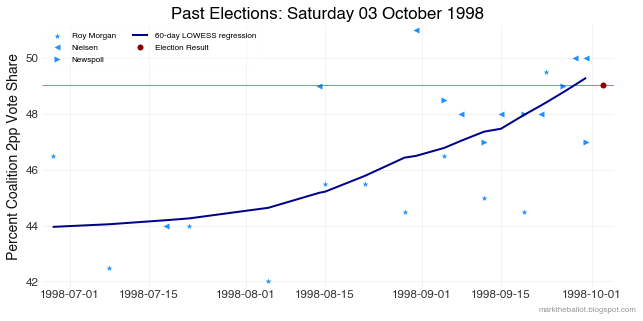

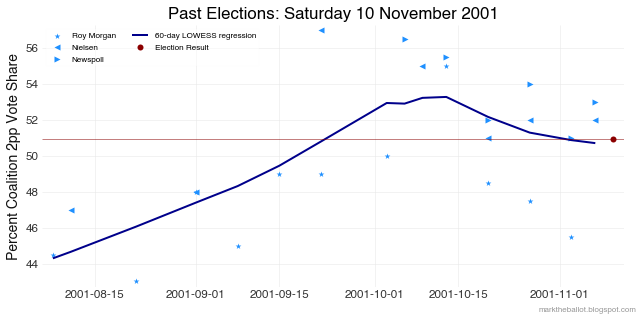

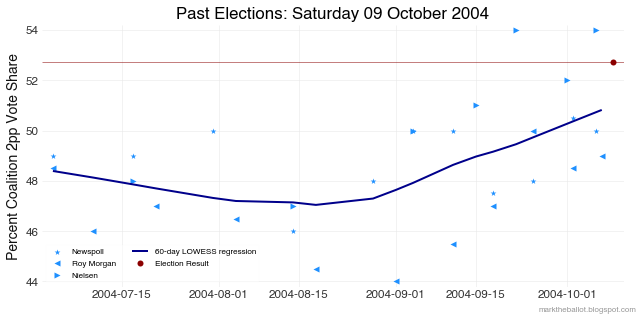

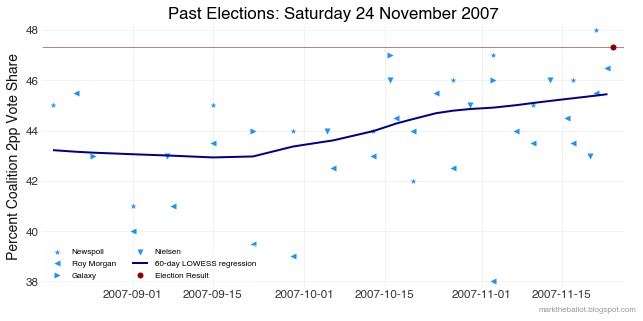

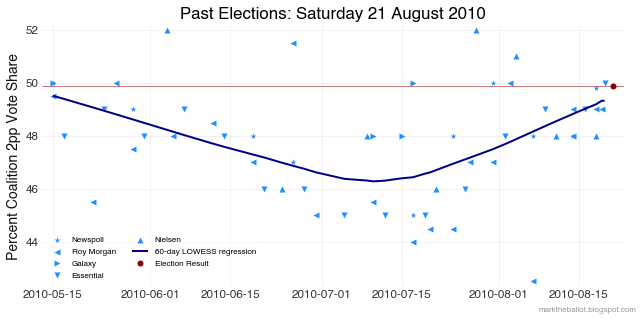

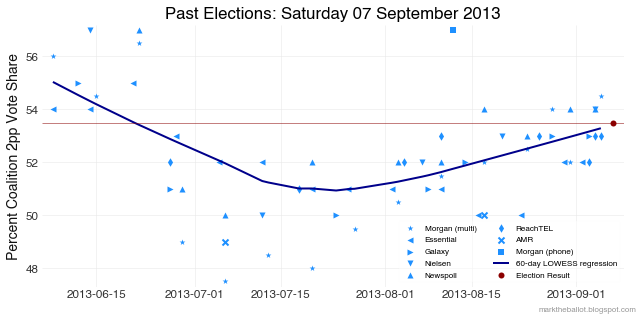

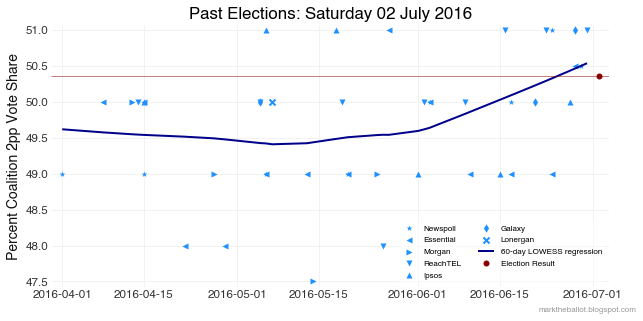

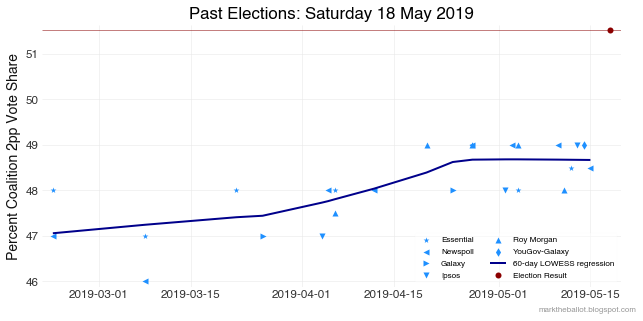

In [7]:
predictions = {}
for election in past_polls['Election'].unique():
    
    # Plot the polling data
    selected = past_polls[past_polls['Election'] == election]
    fix, ax = common.initiate_plot()
    markers = ['*', '<', '>', 'v', '^', 'd', 'x', 's', 'p']
    for i, firm in enumerate(selected['Firm'].unique()):
        firm_data = selected[selected['Firm'] == firm]
        ax.scatter(firm_data['Mean Date'], firm_data['2PP vote L/NP'],
                   color='dodgerblue', marker=markers[i], label=firm)
    
    # summarise polling data
    lowess, period = get_lowess(selected['2PP vote L/NP'], selected['Mean Date'])
    ax.plot(lowess.index, lowess, c='darkblue', lw=2,
            label=f'{period}-day LOWESS regression')

    
    # Plot the result
    election_date = pd.Timestamp(election).strftime("%Y-%m-%d")
    ax.scatter(election, past_elections[election_date],
               marker='o', c='darkred', label='Election Result')
    ax.axhline(past_elections[election_date], c='darkred', lw=0.5)
    
    
    ax.legend(loc='best', ncol=2)
    
    common.plot_finalise(ax, 
        title=f'Past Elections: {pd.Timestamp(election).strftime("%A %d %B %Y")}', 
        ylabel='Percent Coalition 2pp Vote Share', 
        lfooter=None, rfooter='marktheballot.blogspot.com',
        location='../charts/')
        
    predictions[election_date] = [lowess[-1], past_elections[election_date]] # prediction, outcome

## Estimate the relationship between polling and election outcomes

### Data

In [8]:
prediction_df = pd.DataFrame(predictions, index=['Aggregated Polling', 'Election Outcome']).T
prediction_df['Pro-Coalition-bias'] = prediction_df['Aggregated Polling'] - prediction_df['Election Outcome']
prediction_df.index = pd.to_datetime(prediction_df.index)
prediction_df

,Aggregated Polling,Election Outcome,Pro-Coalition-bias
1998-10-03,49.284232,49.02,0.264232
2001-11-10,50.697687,50.95,-0.252313
2004-10-09,50.817737,52.74,-1.922263
2007-11-24,45.444399,47.30,-1.855601
2010-08-21,49.322553,49.88,-0.557447
2013-09-07,53.285304,53.49,-0.204696
2016-07-02,50.535900,50.36,0.175900
2019-05-18,48.670759,51.53,-2.859241


### Statsmodels - classical statsitics

In [9]:
# What does statsmodels give us for the regression
y = prediction_df['Aggregated Polling'].values
x = prediction_df['Election Outcome'].values
fitted = sm.OLS(y, x).fit() 
fitted.summary()

/Users/bryanpalmer/miniconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          1.492e+04
Date:                Fri, 03 Dec 2021   Prob (F-statistic):                    6.50e-13
Time:                        08:34:10   Log-Likelihood:                         -11.956
No. Observations:                   8   AIC:                                      25.91
Df Residuals:                       7   BIC:                                      25.99
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9822      0.008    122.148      0.000       0.963       1.001
==============================================================================
Omnibus:                        1.461   Durbin-Watson:                   1.514
Prob(Omnibus):                  0.482   Jarque-Bera (JB):                0.922
Skew:                          -0.587   Prob(JB):                        0.631
Kurtosis:                       1.822   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
x_const = sm.add_constant(x) 
fitted = sm.OLS(y, x_const).fit() 
fitted.summary()

/Users/bryanpalmer/miniconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     16.75
Date:                Fri, 03 Dec 2021   Prob (F-statistic):            0.00641
Time:                        08:34:10   Log-Likelihood:                -11.952
No. Observations:                   8   AIC:                             27.90
Df Residuals:                       6   BIC:                             28.06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8515     11.956      0.071      0.946     -28.404      30.107
x1             0.9654      0.236      4.093      0.006       0.388       1.543
==============================================================================
Omnibus:                        1.544   Durbin-Watson:                   1.506
Prob(Omnibus):                  0.462   Jarque-Bera (JB):                0.942
Skew:                          -0.583   Prob(JB):                        0.624
Kurtosis:                       1.790   Cond. No.                     1.38e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.38e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Stan - Bayesian estimation

In [11]:
poll_data = {
    'n': len(prediction_df),
    'polls': prediction_df['Aggregated Polling'].astype(float).to_list(),
    'elections': prediction_df['Election Outcome'].astype(float).to_list(),
}

In [12]:
poll_model = """
data {
// Note: expect poll data to be in the range 40 to 60 percentage points ...
    int<lower=1> n;    // number of observations
    vector<lower=0,upper=100>[n] polls;      // Aggregated Poll data
    vector<lower=0,upper=100>[n] elections;  // Election outcome data
}

parameters {
    // historical relationship between polls and elections
    real poll_slope;
    real poll_intercept;
    real<lower=0.000001> poll_sigma; // force half cauchy with lower bound  
}

model {
    // priors on vote difference
    poll_slope ~ normal(1, 1);  
    poll_intercept ~ normal(0, 1);
    poll_sigma ~ cauchy(0, 1);

    // linear regression from 2pp vote difference to seats difference
    // use student_t here for the fatter tails ...
    elections ~ student_t(5, poll_intercept + (poll_slope * polls), poll_sigma); // fatter tails
}

generated quantities {
    // prediction interval on 2pp poll to 2pp election relationship
    real<lower=0,upper=100> predict_interval[n] = normal_rng(poll_intercept + (poll_slope * polls), poll_sigma);
}
"""

In [13]:
poll_posterior = stan.build(poll_model, data=poll_data)

Building: found in cache, done.


In [14]:
poll_fit = poll_posterior.sample(num_chains=4, num_samples=25_000)


Sampling:   0%
Sampling:  25% (26000/104000)
Sampling:  50% (52000/104000)
Sampling:  75% (78000/104000)
Sampling: 100% (104000/104000)
Sampling: 100% (104000/104000), done.
Messages received during sampling:
  Gradient evaluation took 1.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.18 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.04 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.04 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.05 seconds.
  Adjust your expectations accordingly!


### Plot Bayesian estimation

In [15]:
az.summary(poll_fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
poll_slope,1.013,0.022,0.970,1.054,0.000,0.000,39428.0,44737.0,1.0
poll_intercept,0.144,0.993,-1.736,1.984,0.005,0.004,39027.0,45478.0,1.0
poll_sigma,1.157,0.391,0.565,1.884,0.002,0.001,44091.0,44861.0,1.0
predict_interval[0],50.048,1.318,47.561,52.602,0.004,0.003,99925.0,93844.0,1.0
predict_interval[1],51.479,1.320,49.014,54.034,0.004,0.003,99662.0,92791.0,1.0
predict_interval[2],51.598,1.320,49.122,54.157,0.004,0.003,98636.0,89973.0,1.0
predict_interval[3],46.159,1.304,43.668,48.615,0.004,0.003,101717.0,91347.0,1.0
predict_interval[4],50.079,1.317,47.554,52.554,0.004,0.003,100589.0,89639.0,1.0
predict_interval[5],54.093,1.333,51.597,56.649,0.004,0.003,100112.0,89914.0,1.0
predict_interval[6],51.311,1.318,48.816,53.810,0.004,0.003,98087.0,90522.0,1.0


In [16]:
poll_results_df = poll_fit.to_frame()

In [17]:
key_results = poll_results_df[['poll_slope', 'poll_intercept', 'poll_sigma']].median()
key_results

parameters
poll_slope        1.012360
poll_intercept    0.144404
poll_sigma        1.084473
dtype: float64

In [18]:
slope, intercept, sigma = key_results.to_list()
equation = f'y = {slope:.5f}x + {intercept:.5f};  σ={sigma:.5f}' 
equation

'y = 1.01236x + 0.14440;  σ=1.08447'

In [19]:
quants = [0.005, 0.025, 0.100, 0.250, 0.500, 0.750, 0.900, 0.975, 0.995]
LOW, HIGH = 'low', 'high'
ranges = pd.DataFrame({
    '99%': (0.005, 0.995),
    '95%': (0.025, 0.975),
    '80%': (0.100, 0.900),
    '50%': (0.250, 0.750),
}, index=[LOW, HIGH]).T
ranges

,low,high
99%,0.005,0.995
95%,0.025,0.975
80%,0.100,0.900
50%,0.250,0.750


In [20]:
def get_estimates_quants(pattern):

    # Get estimate quantiles
    estimates = (
        poll_results_df[poll_results_df.columns[
            poll_results_df.columns.str.contains(pattern)
        ]]
    )
    estimates.columns = prediction_df.index
    estimates = estimates.quantile(quants).T

    # link to polls
    estimates['Aggregate Poll Forecast'] = prediction_df['Aggregated Polling']
    estimates = estimates.sort_values('Aggregate Poll Forecast')
    
    return estimates

predictions = get_estimates_quants('predict_interval')
predictions

,0.005,0.025,0.1,0.25,0.5,0.75,0.9,0.975,0.995,Aggregate Poll Forecast
2007-11-24,42.323943,43.586445,44.611575,45.369164,46.145375,46.939064,47.734269,48.797572,50.014444,45.444399
2019-05-18,45.590012,46.811967,47.869894,48.623699,49.408265,50.209128,51.019544,52.101133,53.334778,48.670759
1998-10-03,46.188158,47.421893,48.490306,49.253646,50.026904,50.832297,51.633533,52.736063,54.001035,49.284232
2010-08-21,46.237626,47.484904,48.505812,49.275735,50.064476,50.866163,51.667536,52.758997,54.031960,49.322553
2016-07-02,47.439526,48.709671,49.745804,50.516041,51.294181,52.101226,52.908702,53.979000,55.206736,50.535900
2001-11-10,47.628797,48.876656,49.918330,50.683448,51.457261,52.260064,53.074830,54.174831,55.501584,50.697687
2004-10-09,47.809288,48.997774,50.033307,50.797052,51.576912,52.381803,53.200927,54.292155,55.551052,50.817737
2013-09-07,50.143428,51.461438,52.522253,53.283958,54.070631,54.888803,55.698978,56.819592,58.111435,53.285304


In [21]:
def plot_est_quants(estimates, title, **kwargs):
    # plot this relationship
    fig, ax = common.initiate_plot()
    alpha = 0.1
    for x, y in ranges.iterrows():
        low = y[0]
        high = y[1]
        lowpoint = estimates[low]
        highpoint = estimates[high]
        ax.fill_between(x=estimates['Aggregate Poll Forecast'], y1=lowpoint, y2=highpoint,
                    color='darkgreen', alpha = alpha, label=x,)
        alpha += 0.05
    
    ax.plot(estimates['Aggregate Poll Forecast'], estimates[0.500], 
        color='darkgreen', lw=0.5, label='Median')

    ax.scatter(prediction_df['Aggregated Polling'],
               prediction_df['Election Outcome'],
               label='Previous elections')

    ax.axhline(50, lw=0.5, color='#555555')
    ax.axvline(50, lw=0.5, color='#555555')

    for x, y, s in zip(prediction_df['Aggregated Polling'],
                       prediction_df['Election Outcome']+0.06,
                       prediction_df.index.year.astype(str)):
        ax.text(x, y, s, fontsize='x-small', va='bottom', ha='center')
    

    ax.legend(loc='best')
    common.plot_finalise(ax, 
                  title=title,
                  xlabel='Coalition 2pp Aggregated Polling prior to Election (%)', 
                  ylabel='Coalition 2pp Election Outcome (%)',
                  lfooter=equation,
                  **kwargs)

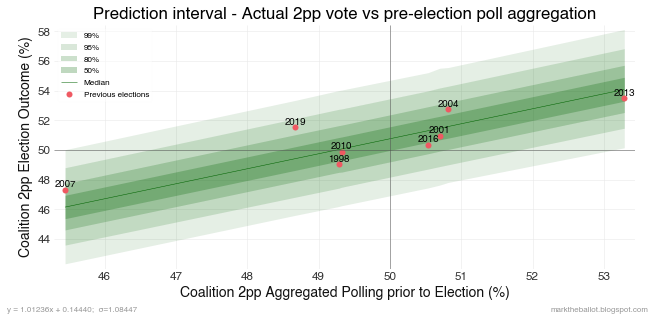

In [22]:
plot_est_quants(predictions, 
                'Prediction interval - Actual 2pp vote vs pre-election poll aggregation')

## Save key statistics for use in seats model

In [23]:
key_results.to_csv('../historical-data/poll-to-election-outcome.csv')